# Exploratory Data Analysis for SST-2 dataset

The Stanford Sentiment Treebank dataset is a collection of sentences from movie reviews annotated with fine-grained sentiment labels. The idea is to use this dataset along with synthetic data to train a model with better baseline performance.

In this notebook, we will perform an exploratory data analysis on the SST-2 dataset.

## Data Loading
I am using the `datasets` library from Hugging Face to load the SST-2 dataset. This provides a nice in built train/test/validation split out of the box. This way I don't have to worry about doing it manually with `scikit-learn`. I'll download the actual data as parquet files. 

In [5]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/sst2")

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [6]:
print(ds)
print("\n Training Data sample: ")
print(ds["train"][0])
print("\n Testing Data sample: ")
print(ds["test"][0])
print("\n Validation Data sample: ")
print(ds["validation"][0])


DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

 Training Data sample: 
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}

 Testing Data sample: 
{'idx': 0, 'sentence': 'uneasy mishmash of styles and genres .', 'label': -1}

 Validation Data sample: 
{'idx': 0, 'sentence': "it 's a charming and often affecting journey . ", 'label': 1}


### Sequence Length Interpretation
1. Maximum sequence length is 52 words. This should be fine for most transformer models.
2. More importantly, 95th percentile length is 28 words. This means that we can probably set a maximum token limit of 30-32 tokens and not lose much data.

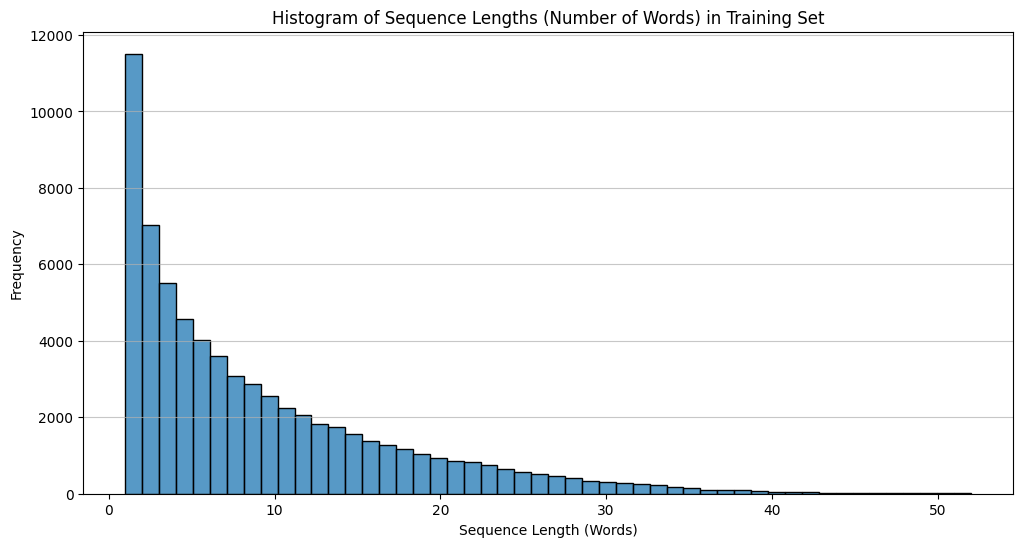

Sequence Length Statistics (Words):
count    67349.000000
mean         9.409553
std          8.073806
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
90%         21.000000
95%         26.000000
99%         35.000000
max         52.000000
dtype: float64

Maximum sequence length: 52 words
95th percentile length: 26.00 words


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd # Added for Series/DataFrame operations

# Calculate sentence lengths (number of words) for the training set
train_sentences = ds['train']['sentence']
train_lengths = [len(sentence.split()) for sentence in train_sentences]

# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(train_lengths, bins=50, kde=False) # Increased bins for better resolution
plt.title('Histogram of Sequence Lengths (Number of Words) in Training Set')
plt.xlabel('Sequence Length (Words)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.7)
plt.show()

# Calculate and print key statistics
len_series = pd.Series(train_lengths)
print("Sequence Length Statistics (Words):")
print(len_series.describe(percentiles=[.25, .5, .75, .90, .95, .99]))

max_len = len_series.max()
len_95_pct = len_series.quantile(0.95)
print(f"\nMaximum sequence length: {max_len} words")
print(f"95th percentile length: {len_95_pct:.2f} words")


### Label Distribution
This also looks good, but that was expected since this is a widely used dataset.

Label distribution in training set:
0    29780
1    37569
Name: count, dtype: int64

Total training examples: 67349


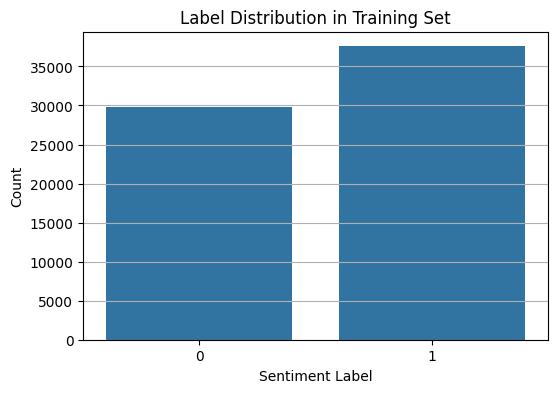

In [11]:
# Get labels from the training set
train_labels = ds['train']['label']

# Use pandas Series for easy value counting
label_series = pd.Series(train_labels)
label_counts = label_series.value_counts().sort_index()



print("Label distribution in training set:")
print(label_counts)
print(f"\nTotal training examples: {len(train_labels)}")

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Label Distribution in Training Set')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

In [14]:
from datasets import disable_caching
disable_caching()
ds = load_dataset("stanfordnlp/sst2")
ds.save_to_disk("./data/raw") # Use relative path

Saving the dataset (0/1 shards):   0%|          | 0/67349 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/872 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1821 [00:00<?, ? examples/s]

## Term Frequency and NGram Analysis
At this point, I've downloaded the raw data and written `src/data/clean.py` to clean the data. At the moment, it just lowercases everything and squeezes whitespace. 
Now we can perform other analysis on the cleaned data.

In [27]:
from datasets import load_from_disk
ds_clean = load_from_disk("./data/clean")

cleaned_train_texts = ds_clean["train"]["text"]


Text(0, 0.5, 'Term')

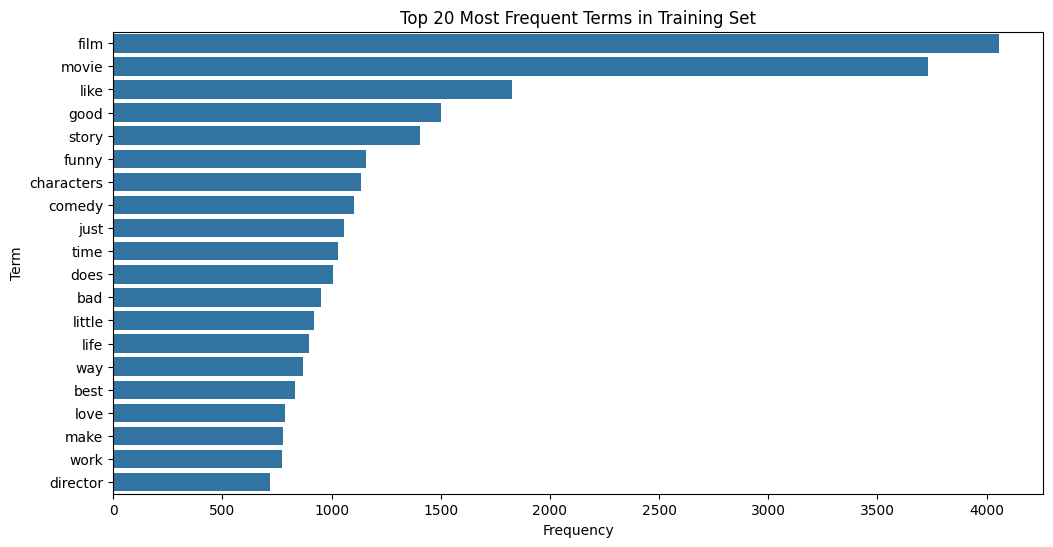

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english")
X = vectorizer.fit_transform(cleaned_train_texts)

term_counts = X.sum(axis=0)
terms = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({"term": terms, "count": term_counts.tolist()[0]}).sort_values("count", ascending=False)

# Plot top 20 terms
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="term", data=freq_df.head(20))
plt.title("Top 20 Most Frequent Terms in Training Set")
plt.xlabel("Frequency")
plt.ylabel("Term")

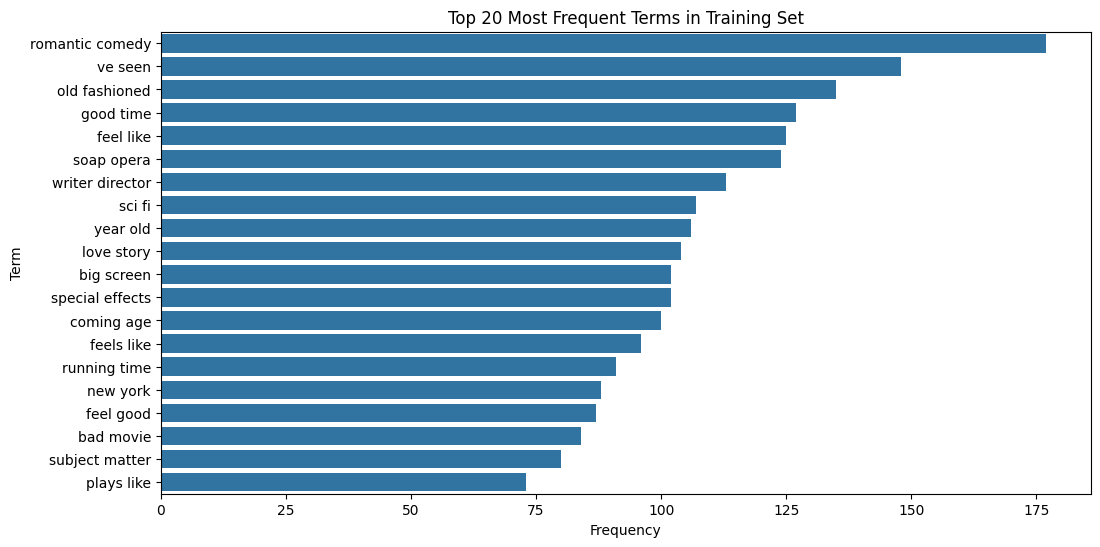

In [29]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")
X = vectorizer.fit_transform(cleaned_train_texts)

term_counts = X.sum(axis=0)
terms = vectorizer.get_feature_names_out()

freq_df = pd.DataFrame({"term": terms, "count": term_counts.tolist()[0]}).sort_values("count", ascending=False)

# Plot top 20 terms
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="term", data=freq_df.head(20))
plt.title("Top 20 Most Frequent Terms in Training Set")
plt.xlabel("Frequency")
plt.ylabel("Term")
plt.show()

